In [2]:
import parmed as pmd
    
top_path = "1anf_malremoved_t3p.parm7"
coord_path = "1anf_malremoved_t3p.rst7"

structure = pmd.load_file("1anf_malremoved_t3p.parm7", "1anf_malremoved_t3p.rst7")

print(f"Bonds: {len(structure.bonds)}")
print(f"Angles: {len(structure.angles)}")
print(f"Dihedrals: {len(structure.dihedrals)}")
print(f"Atoms: {len(structure.atoms)}")


Bonds: 39298
Angles: 10556
Dihedrals: 25646
Atoms: 39237


In [8]:
# ParmEd
import parmed as pmd
p = pmd.load_file("1anf_malremoved_t3p.parm7", "1anf_malremoved_t3p.rst7")
print("ParmEd:", len(p.atoms), len(p.angles), len(p.dihedrals))

# OpenMM
import openmm
from openmm.app import AmberPrmtopFile, AmberInpcrdFile
from openmm import unit
from openmm.app import PME, HBonds

prmtop = AmberPrmtopFile("1anf_malremoved_t3p.parm7")
inpcrd = AmberInpcrdFile("1anf_malremoved_t3p.rst7")
system = prmtop.createSystem(nonbondedMethod=PME, nonbondedCutoff=1*unit.nanometer, constraints=HBonds)

for force in system.getForces():
    if isinstance(force, openmm.HarmonicBondForce):
        print("HarmonicBondForce:", force.getNumBonds())
    elif isinstance(force, openmm.HarmonicAngleForce):
        print("HarmonicAngleForce:", force.getNumAngles())
    elif isinstance(force, openmm.PeriodicTorsionForce):
        print("PeriodicTorsionForce:", force.getNumTorsions())
    elif isinstance(force, openmm.NonbondedForce):
        print("NonbondedForce:", force.getNumParticles())
    else:
        print(force.__class__.__name__)



ParmEd: 39237 10556 25646
HarmonicBondForce: 2947
HarmonicAngleForce: 10556
PeriodicTorsionForce: 25646
NonbondedForce: 39237
CMMotionRemover


In [27]:
import mdtraj as md
from openmm.app import AmberPrmtopFile, AmberInpcrdFile, Simulation, PME, HBonds
from openmm import LangevinIntegrator, Platform, unit

# ==== INPUT FILES ====
prmtop_path = "1anf_malremoved_t3p.parm7"
rst7_path = "1anf_malremoved_t3p.rst7"
dcd_path = apo_dcd
top_pdb_path = prmtop_path  # MDTraj needs a PDB or similar with atom names

# ==== LOAD AMBER SYSTEM ====
print("Loading Amber topology and coordinates...")
prmtop = AmberPrmtopFile(prmtop_path)
inpcrd = AmberInpcrdFile(rst7_path)

system = prmtop.createSystem(
    nonbondedMethod=PME,
    nonbondedCutoff=1.0 * unit.nanometer,
    constraints=HBonds,
)

integrator = LangevinIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 2 * unit.femtoseconds)
platform = Platform.getPlatformByName("CPU")  # or "CUDA"
simulation = Simulation(prmtop.topology, system, integrator, platform)

# Load initial positions and box
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

# ==== READ TRAJECTORY WITH MDTraj ====
print("Loading trajectory with MDTraj...")
traj = md.load_dcd(dcd_path, top=top_pdb_path)

# ==== EVALUATE ENERGY PER FRAME ====
print("Evaluating energy per frame...")
for i, frame in enumerate(traj):
    # Convert MDTraj frame positions to OpenMM units
    positions = frame.xyz[0] * unit.nanometer
    box_vectors = frame.unitcell_vectors[0] * unit.nanometer

    simulation.context.setPositions(positions)
    simulation.context.setPeriodicBoxVectors(*box_vectors)

    state = simulation.context.getState(getEnergy=True)
    energy = state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    print(f"Frame {i:04d}: {energy:.2f} kJ/mol")


Loading Amber topology and coordinates...
Loading trajectory with MDTraj...
Evaluating energy per frame...
Frame 0000: -485100.06 kJ/mol
Frame 0001: -484118.33 kJ/mol
Frame 0002: -484798.30 kJ/mol
Frame 0003: -485128.37 kJ/mol
Frame 0004: -485689.40 kJ/mol
Frame 0005: -485635.98 kJ/mol
Frame 0006: -485870.13 kJ/mol
Frame 0007: -484228.92 kJ/mol
Frame 0008: -485221.23 kJ/mol
Frame 0009: -486087.45 kJ/mol
Frame 0010: -485855.47 kJ/mol
Frame 0011: -485535.31 kJ/mol
Frame 0012: -486056.51 kJ/mol
Frame 0013: -485047.98 kJ/mol
Frame 0014: -483976.88 kJ/mol
Frame 0015: -485726.85 kJ/mol
Frame 0016: -484691.78 kJ/mol
Frame 0017: -484973.20 kJ/mol
Frame 0018: -485768.32 kJ/mol
Frame 0019: -483654.70 kJ/mol
Frame 0020: -486732.81 kJ/mol
Frame 0021: -483952.91 kJ/mol
Frame 0022: -484597.15 kJ/mol
Frame 0023: -487219.99 kJ/mol
Frame 0024: -485074.30 kJ/mol
Frame 0025: -484378.99 kJ/mol
Frame 0026: -484571.46 kJ/mol
Frame 0027: -485219.72 kJ/mol
Frame 0028: -484108.90 kJ/mol
Frame 0029: -485788.95 

KeyboardInterrupt: 

In [24]:
DCDFile(dcd_path)

TypeError: DCDFile.__init__() missing 2 required positional arguments: 'topology' and 'dt'

In [ ]:
import pyrosetta
pyrosetta.init("-ignore_unrecognized_res true")  # Avoid crash on unknown atoms

from pyrosetta import pose_from_pdb, get_fa_scorefxn

scorefxn = get_fa_scorefxn()  # default is ref2015


In [33]:
import os
import mdtraj as md

sim = 2
apo_top = "1anf_malremoved_t3p.parm7"
apo_dcd = f"simulation_{sim:02d}/npt_production_{sim:02d}.dcd"

temp_folder = f"simulation_{sim:02d}_pdbs/"
os.makedirs(temp_folder, exist_ok=True)

traj = md.load_dcd(apo_dcd, top=apo_top)
num_frames = 0
for i, frame in enumerate(traj):
    frame.save_pdb(temp_folder+f"frame_{i:04d}.pdb")
    num_frames += 1
    if num_frames > 1000 * 0.25: break




In [34]:
import numpy as np

energies = []
for i in range(num_frames):
    pose = pose_from_pdb(temp_folder+f"frame_{i:04d}.pdb")
    total_score = scorefxn(pose)
    energies.append(total_score)
    
energies = np.array(energies)


core.import_pose.import_pose: File 'simulation_02_pdbs/frame_0000.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: Adding undetected upper terminus type to residue 370,  369 A
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 2 atoms at position 1 in file simulation_02_pdbs/frame_0000.pdb. Best match rsd_type:  LYS:NtermProteinFull
core.import_pose.import_pose: File 'simulation_02_pdbs/frame_0001.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: Adding undetected upper terminus type to residue 370,  369 A
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 2 atoms at position 1 in file simulation_02_pdbs/frame_0001.pdb. Best match rsd_type:  LYS:NtermProteinFull
core.import_pose.import_pose: File 'simulation_02_pdbs/frame_0002.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: Adding undetected upper terminus type to residue 370,  369 A
cor

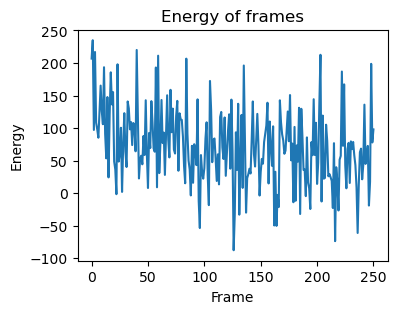

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3))
plt.plot(energies)
plt.xlabel("Frame")
plt.ylabel("Energy")
plt.title("Energy of frames")
# plt.savefig("energies.png")
plt.show()